In [1]:
from astropy.modeling import models, fitting
from dendrocat import RadioSource
from astropy.io import fits
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import sys
import importlib
from astropy.wcs import WCS
from scipy import interpolate
import pandas as pd
from astropy import units as u
import radio_beam
from astropy.table import Table
from radio_beam import Beam
from astropy import coordinates
from astropy import wcs
from astropy.nddata.utils import Cutout2D
#from dendrocat.aperture import Ellipse
from matplotlib.patches import Rectangle, Ellipse
import regions
from scipy.optimize import curve_fit
from regions import EllipseAnnulusSkyRegion, EllipseAnnulusPixelRegion
import Paths.Paths as paths

Path = paths.filepaths()


### deconvolved FWHM histogram, S/N is estimated based on size uncertainties

ho 30 73 13 18
101 106 67 25
0 0.0 0.0 8.525097687794012e-06 4.279391261330431e-06
1 0.0 0.0 0.0 0.0
2 2.4303957932344634e-05 1.3575757802110083e-05 1.4634723861258542e-05 5.45716339398475e-06
3 0.0 0.0 0.0 0.0
4 0.0 0.0 0.0 0.0
5 0.0 0.0 1.1501534616322407e-05 5.064653505763791e-06
6 0.0 0.0 0.0 0.0
7 0.0 0.0 0.0 0.0
8 0.0 0.0 0.0 0.0
9 0.0 0.0 1.2655917653901643e-05 1.0396248123654278e-05
10 0.0 0.0 1.4707820057434143e-05 8.56012952640818e-06
11 0.0 0.0 1.4687221090813221e-05 7.352665380103757e-06
12 0.0 0.0 9.3413410327014e-06 7.637216222187803e-06
13 0.0 0.0 1.1083130482023976e-05 5.968484009985412e-06
14 0.0 0.0 1.3240865176647615e-05 6.409876599711964e-06
15 0.0 0.0 9.226540087620754e-06 5.540888595026175e-06
16 0.0 0.0 0.0 0.0
17 0.0 0.0 1.5881867504135417e-05 3.345930210349321e-06
18 0.0 0.0 0.0 0.0
19 2.5792475732128173e-05 1.811047243187111e-05 1.3514057428386934e-05 1.1254492482674451e-05
20 0.0 0.0 1.0284485814905942e-05 5.1587232850036955e-06
21 2.167880474590344e-05 1.421

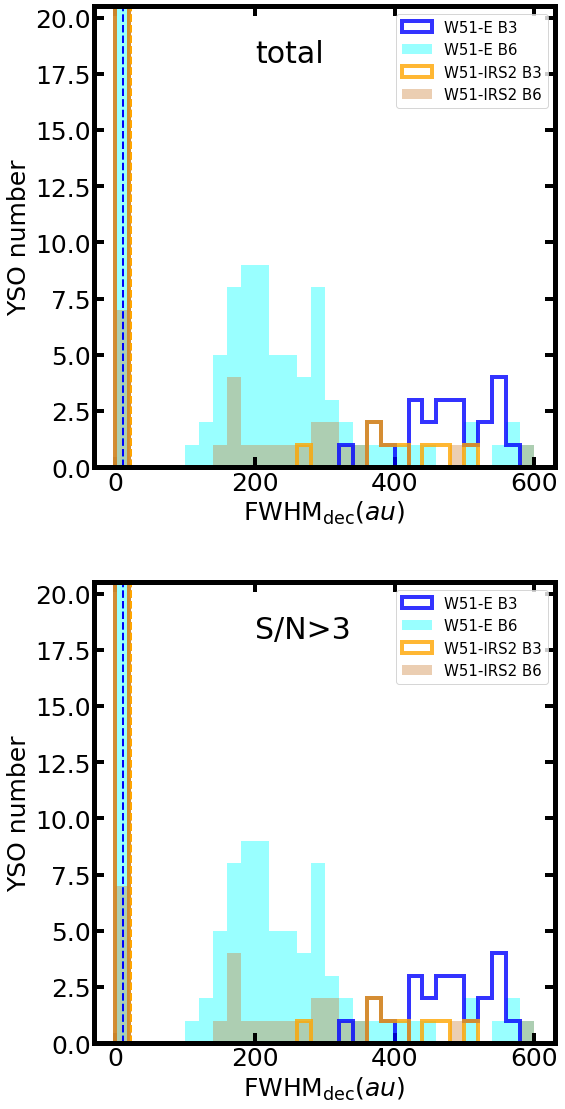

In [2]:
from astropy.table import Table
import matplotlib as mpl
import astropy.units as u
import astropy.constants as c
plt.rcParams['axes.labelsize']=25
plt.rcParams['xtick.labelsize']=25
plt.rcParams['ytick.labelsize']=25
plt.rcParams['axes.titlesize']=25
mpl.rcParams['axes.linewidth'] = 5
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 4
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 4
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.minor.width'] = 2
params = {"xtick.top": True, "ytick.right": True, "xtick.direction": "in", "ytick.direction": "in"}
plt.rcParams.update(params)
fig = plt.figure(figsize=(8,16))
ax1 = fig.add_axes([0.15,0.58,0.8,0.4])
ax2 = fig.add_axes([0.15,0.08,0.8,0.4])
w51e_b3_flux_fits = Table.read(Path.w51e_b3_flux)
w51e_b6_flux_fits = Table.read(Path.w51e_b6_flux)
w51n_b3_flux_fits = Table.read(Path.w51n_b3_flux)
w51n_b6_flux_fits = Table.read(Path.w51n_b6_flux)
w51e_b6_flux_conv_fits = Table.read(Path.w51e_b6_conv_flux)
w51n_b6_flux_conv_fits = Table.read(Path.w51n_b6_conv_flux)

w51e_b3_flux = w51e_b3_flux_fits['flux']
w51e_b6_flux = w51e_b6_flux_fits['flux']
w51n_b3_flux = w51n_b3_flux_fits['flux']
w51n_b6_flux = w51n_b6_flux_fits['flux']

w51e_catalog = Table.read(Path.w51e_dendro_matched_catalog)
w51n_catalog = Table.read(Path.w51n_dendro_matched_catalog)

w51e_b3_detected = w51e_catalog['b3_xpix']>0
w51e_b6_detected = w51e_catalog['b6_xpix']>0
w51n_b3_detected = w51n_catalog['b3_xpix']>0
w51n_b6_detected = w51n_catalog['b6_xpix']>0



w51e_b3_major = w51e_b3_flux_fits['deconvolved_major'][w51e_b3_detected]
w51e_b6_major = w51e_b6_flux_fits['deconvolved_major'][w51e_b6_detected]
w51n_b3_major = w51n_b3_flux_fits['deconvolved_major'][w51n_b3_detected]
w51n_b6_major = w51n_b6_flux_fits['deconvolved_major'][w51n_b6_detected]
w51e_b3_minor = w51e_b3_flux_fits['deconvolved_minor'][w51e_b3_detected]
w51e_b6_minor = w51e_b6_flux_fits['deconvolved_minor'][w51e_b6_detected]
w51n_b3_minor = w51n_b3_flux_fits['deconvolved_minor'][w51n_b3_detected]
w51n_b6_minor = w51n_b6_flux_fits['deconvolved_minor'][w51n_b6_detected]

print('ho',len(np.where(w51e_b3_major>0)[0]), len(np.where(w51e_b6_major>0)[0]), len(np.where(w51n_b3_major>0)[0]), len(np.where(w51n_b6_major>0)[0]))
"""
w51e_b3_major_upperr = w51e_b3_flux_fits['deconvolved_major_upperr']
w51e_b6_major_upperr = w51e_b6_flux_fits['deconvolved_major_upperr']
w51n_b3_major_upperr = w51n_b3_flux_fits['deconvolved_major_upperr']
w51n_b6_major_upperr = w51n_b6_flux_fits['deconvolved_major_upperr']
w51e_b3_minor_upperr = w51e_b3_flux_fits['deconvolved_minor_upperr']
w51e_b6_minor_upperr = w51e_b6_flux_fits['deconvolved_minor_upperr']
w51n_b3_minor_upperr = w51n_b3_flux_fits['deconvolved_minor_upperr']
w51n_b6_minor_upperr = w51n_b6_flux_fits['deconvolved_minor_upperr']

w51e_b3_major_lowerr = w51e_b3_flux_fits['deconvolved_major_lowerr']
w51e_b6_major_lowerr = w51e_b6_flux_fits['deconvolved_major_lowerr']
w51n_b3_major_lowerr = w51n_b3_flux_fits['deconvolved_major_lowerr']
w51n_b6_major_lowerr = w51n_b6_flux_fits['deconvolved_major_lowerr']
w51e_b3_minor_lowerr = w51e_b3_flux_fits['deconvolved_minor_lowerr']
w51e_b6_minor_lowerr = w51e_b6_flux_fits['deconvolved_minor_lowerr']
w51n_b3_minor_lowerr = w51n_b3_flux_fits['deconvolved_minor_lowerr']
w51n_b6_minor_lowerr = w51n_b6_flux_fits['deconvolved_minor_lowerr']
"""
w51e_catalog = Table.read(Path.w51e_dendro_matched_catalog) 
w51n_catalog = Table.read(Path.w51n_dendro_matched_catalog) 

isoverlap_w51e = w51e_catalog['is_overlap']
isoverlap_w51n = w51n_catalog['is_overlap']

print(len(w51e_b3_major), len(w51e_b6_major), len(w51n_b3_major), len(w51n_b6_major))

# isoverlap should be an index of band 6 size array because the b6 size of source outside
# of B6 FOV is assigned to be 0 but they don't have zero physical size.
for i in range(len(w51e_b3_major)):
    print(i, w51e_b3_major[i], w51e_b3_minor[i],w51e_b6_major[i], w51e_b6_minor[i])
"""
w51e_b3_avg_size = np.sqrt(w51e_b3_major * w51e_b3_minor) 
w51e_b6_avg_size = np.sqrt(w51e_b6_major[isoverlap_w51e] * w51e_b6_minor[isoverlap_w51e])
w51n_b3_avg_size = np.sqrt(w51n_b3_major * w51n_b3_minor) 
w51n_b6_avg_size = np.sqrt(w51n_b6_major[isoverlap_w51n] * w51n_b6_minor[isoverlap_w51n]) 

w51e_b3_avg_size = w51e_b3_major * 2 / 2.355 
w51e_b6_avg_size = w51e_b6_major[isoverlap_w51e] * 2 / 2.355 
w51n_b3_avg_size = w51n_b3_major * 2 / 2.355 
w51n_b6_avg_size = w51n_b6_major[isoverlap_w51n] * 2 / 2.355 
"""
def get_max_size(size_major, size_minor):
    sizearr = []
    idxarr = []
    for i in range(len(size_major)):
        if size_major[i]>size_minor[i]:
            sizearr.append(size_major[i])
        else:
            sizearr.append(size_minor[i])
            idxarr.append(i)
    return np.array(sizearr), np.array(idxarr)

#w51e_b3_max_size,w51e_b3_idx = get_max_size(w51e_b3_major, w51e_b3_minor)
#w51e_b6_max_size,w51e_b6_idx = get_max_size(w51e_b6_major[isoverlap_w51e], w51e_b6_major[isoverlap_w51e]) 
#w51n_b3_max_size,w51n_b3_idx = get_max_size(w51n_b3_major, w51n_b3_minor)
#w51n_b6_max_size,w51n_b6_idx = get_max_size(w51n_b6_major[isoverlap_w51n], w51n_b6_minor[isoverlap_w51n])

w51e_b3_max_size_au = w51e_b3_major * np.pi/180 * 5.4*1000*206265
w51e_b6_max_size_au = w51e_b6_major * np.pi/180 * 5.4*1000*206265
w51n_b3_max_size_au = w51n_b3_major * np.pi/180 * 5.4*1000*206265
w51n_b6_max_size_au = w51n_b6_major * np.pi/180 * 5.4*1000*206265
"""
w51e_b3_max_size_upp = np.array([w51e_b3_minor_upperr[i] if i in w51e_b3_idx else w51e_b3_major_upperr[i] for i in range(len(w51e_b3_max_size))])
w51e_b6_max_size_upp = np.array([w51e_b6_minor_upperr[i] if i in w51e_b6_idx else w51e_b6_major_upperr[i] for i in range(len(w51e_b6_max_size))]) 
w51n_b3_max_size_upp = np.array([w51n_b3_minor_upperr[i] if i in w51n_b3_idx else w51n_b3_major_upperr[i] for i in range(len(w51n_b3_max_size))]) 
w51n_b6_max_size_upp = np.array([w51n_b6_minor_upperr[i] if i in w51n_b6_idx else w51n_b6_major_upperr[i] for i in range(len(w51n_b6_max_size))]) 

w51e_b3_max_size_low = np.array([w51e_b3_minor_lowerr[i] if i in w51e_b3_idx else w51e_b3_major_lowerr[i] for i in range(len(w51e_b3_max_size))]) 
w51e_b6_max_size_low = np.array([w51e_b6_minor_lowerr[i] if i in w51e_b6_idx else w51e_b6_major_lowerr[i] for i in range(len(w51e_b6_max_size))]) 
w51n_b3_max_size_low = np.array([w51n_b3_minor_lowerr[i] if i in w51n_b3_idx else w51n_b3_major_lowerr[i] for i in range(len(w51n_b3_max_size))]) 
w51n_b6_max_size_low = np.array([w51n_b6_minor_lowerr[i] if i in w51n_b6_idx else w51n_b6_major_lowerr[i] for i in range(len(w51n_b6_max_size))]) 
"""

"""
w51e_b3_avg_size_upp = np.sqrt(w51e_b3_major_upperr * w51e_b3_minor_upperr)
w51e_b6_avg_size_upp = np.sqrt(w51e_b6_major_upperr * w51e_b6_minor_upperr)[isoverlap_w51e]
w51n_b3_avg_size_upp = np.sqrt(w51n_b3_major_upperr * w51n_b3_minor_upperr)
w51n_b6_avg_size_upp = np.sqrt(w51n_b6_major_upperr * w51n_b6_minor_upperr)[isoverlap_w51n]

w51e_b3_avg_size_low = np.sqrt(w51e_b3_major_lowerr * w51e_b3_minor_lowerr)
w51e_b6_avg_size_low = np.sqrt(w51e_b6_major_lowerr * w51e_b6_minor_lowerr)[isoverlap_w51e]
w51n_b3_avg_size_low = np.sqrt(w51n_b3_major_lowerr * w51n_b3_minor_lowerr)
w51n_b6_avg_size_low = np.sqrt(w51n_b6_major_lowerr * w51n_b6_minor_lowerr)[isoverlap_w51n]  
"""

#w51e_b3_size_err = w51e_b3_max_size_upp - w51e_b3_max_size_low
#w51e_b6_size_err = w51e_b6_max_size_upp - w51e_b6_max_size_low
#w51n_b3_size_err = w51n_b3_max_size_upp - w51n_b3_max_size_low
#w51n_b6_size_err = w51n_b6_max_size_upp - w51n_b6_max_size_low

"""
w51e_b3_snr = w51e_b3_max_size/w51e_b3_size_err
w51e_b6_snr = w51e_b6_max_size/w51e_b6_size_err
w51n_b3_snr = w51n_b3_max_size/w51n_b3_size_err
w51n_b6_snr = w51n_b6_max_size/w51n_b6_size_err

w51e_b3_snrind = np.where(w51e_b3_snr>3)[0]
w51e_b6_snrind = np.where(w51e_b6_snr>3)[0]
w51n_b3_snrind = np.where(w51n_b3_snr>3)[0]
w51n_b6_snrind = np.where(w51n_b6_snr>3)[0]
"""

bins = np.linspace(0,600,31)
print(len(w51e_b3_max_size_au), len(w51e_b6_max_size_au), len(w51n_b3_max_size_au), len(w51n_b6_max_size_au))
print(len(np.where(w51e_b3_max_size_au>0)[0]), len(np.where(w51e_b6_max_size_au>0)[0]), len(np.where(w51n_b3_max_size_au>0)[0]), len(np.where(w51n_b6_max_size_au>0)[0]))
ax1.hist(w51e_b3_max_size_au, bins=bins, facecolor='none',edgecolor='b', histtype='step',label='W51-E B3',lw=4,alpha=0.8)
ax1.hist(w51e_b6_max_size_au, bins=bins, color='cyan',label='W51-E B6',lw=4,alpha=0.4)
ax1.hist(w51n_b3_max_size_au, bins=bins, facecolor='none',edgecolor='orange', histtype='step',label='W51-IRS2 B3',lw=4,alpha=0.8)
ax1.hist(w51n_b6_max_size_au, bins=bins, color='peru',label='W51-IRS2 B6',lw=4,alpha=0.4)
print('median',np.median(w51e_b3_max_size_au),np.median(w51e_b6_max_size_au),np.median(w51n_b3_max_size_au),np.median(w51n_b6_max_size_au))
ax1.set_xlabel(r'${\rm FWHM}_{\rm dec} (au)$')
ax1.set_ylabel('YSO number')
ax1.legend(fontsize=15)

ax2.hist(w51e_b3_max_size_au, bins=bins, facecolor='none',edgecolor='b', histtype='step',label='W51-E B3',lw=4,alpha=0.8)
ax2.hist(w51e_b6_max_size_au, bins=bins, color='cyan',label='W51-E B6',lw=4,alpha=0.4)
ax2.hist(w51n_b3_max_size_au, bins=bins, facecolor='none',edgecolor='orange', histtype='step',label='W51-IRS2 B3',lw=4,alpha=0.8)
ax2.hist(w51n_b6_max_size_au, bins=bins, color='peru',label='W51-IRS2 B6',lw=4,alpha=0.4)

w51e_b6_hdr = fits.getheader(Path.w51e_b6_cont)
w51n_b6_hdr = fits.getheader(Path.w51n_b6_cont)
w51e_b3_hdr = fits.getheader(Path.w51e_b3_tt0)
w51n_b3_hdr = fits.getheader(Path.w51n_b3_tt0)

beam_w51e_b6 = Beam.from_fits_header(w51e_b6_hdr)    
beam_w51n_b6 = Beam.from_fits_header(w51n_b6_hdr)    
beam_w51e_b3 = Beam.from_fits_header(w51e_b3_hdr)    
beam_w51n_b3 = Beam.from_fits_header(w51n_b3_hdr)

max_size_w51e_b6 = np.sqrt(beam_w51e_b6.major.value*beam_w51e_b6.minor.value)*np.pi/180*5.4*1000*206265
max_size_w51n_b6 = np.sqrt(beam_w51n_b6.major.value*beam_w51n_b6.minor.value)*np.pi/180*5.4*1000*206265
max_size_w51e_b3 = np.sqrt(beam_w51e_b3.major.value*beam_w51e_b3.minor.value)*np.pi/180*5.4*1000*206265
max_size_w51n_b3 = np.sqrt(beam_w51n_b3.major.value*beam_w51n_b3.minor.value)*np.pi/180*5.4*1000*206265

print(np.min(w51e_b3_max_size_au[w51e_b3_max_size_au>0]))
print(np.min(w51e_b6_max_size_au[w51e_b6_max_size_au>0]))
print(np.min(w51n_b3_max_size_au[w51n_b3_max_size_au>0]))
print(np.min(w51n_b6_max_size_au[w51n_b6_max_size_au>0]))

print(np.max(w51e_b3_max_size_au[w51e_b3_max_size_au>0]))
print(np.max(w51e_b6_max_size_au[w51e_b6_max_size_au>0]))
print(np.max(w51n_b3_max_size_au[w51n_b3_max_size_au>0]))
print(np.max(w51n_b6_max_size_au[w51n_b6_max_size_au>0]))



ax2.set_xlabel(r'${\rm FWHM}_{\rm dec} (au)$')
ax2.set_ylabel('YSO number')
ax2.legend(fontsize=15)
ax1.set_ylim(0,20.5)
ax2.set_ylim(0,20.5)
ax1.text(200,18,'total',fontsize=30)
ax2.text(200,18,'S/N>3',fontsize=30)


hdrNB3 = fits.getheader(Path.w51e_b3_tt0)  
hdrNB6 = fits.getheader(Path.w51e_b6_cont)  
wcsNB3 = WCS(hdrNB3,naxis=2)
wcsNB6 = WCS(hdrNB6,naxis=2)

scaleNB6 = wcsNB6.proj_plane_pixel_scales()[0]
scaleNB3 = wcsNB3.proj_plane_pixel_scales()[0]

my_beamNB6 = Beam.from_fits_header(hdrNB6)
my_beamNB3 = Beam.from_fits_header(hdrNB3)
sig_to_fwhm = np.sqrt(2*np.log(2))*2
fwhm_dec_b6_min =sig_to_fwhm*np.sqrt((my_beamNB6.major.value/scaleNB6.value/sig_to_fwhm+0.01) 
                                 * (my_beamNB6.minor.value/scaleNB6.value/sig_to_fwhm+0.01) 
                                 - my_beamNB6.major.value/scaleNB6.value/sig_to_fwhm*my_beamNB6.minor.value/scaleNB6.value/sig_to_fwhm)

fwhm_dec_b3_min =sig_to_fwhm*np.sqrt((my_beamNB3.major.value/scaleNB3.value/sig_to_fwhm+0.01) 
                                 * (my_beamNB3.minor.value/scaleNB3.value/sig_to_fwhm+0.01) 
                                 - my_beamNB3.major.value/scaleNB3.value/sig_to_fwhm*my_beamNB3.minor.value/scaleNB3.value/sig_to_fwhm)

w51e_b6_min_size = fwhm_dec_b6_min*scaleNB6.value*np.pi/180*5.4*1000*206265
w51e_b3_min_size = fwhm_dec_b3_min*scaleNB3.value*np.pi/180*5.4*1000*206265
w51n_b6_min_size = fwhm_dec_b6_min*scaleNB6.value*np.pi/180*5.4*1000*206265
w51n_b3_min_size = fwhm_dec_b3_min*scaleNB3.value*np.pi/180*5.4*1000*206265

ax1.vlines(w51e_b6_min_size,0,35,color='cyan',lw=2,ls='dashed')
ax1.vlines(w51e_b3_min_size,0,35,color='peru',lw=2,ls='dashed')
ax1.vlines(w51n_b6_min_size,0,35,color='b',lw=2,ls='dashed')
ax1.vlines(w51n_b3_min_size,0,35,color='orange',lw=2,ls='dashed')

ax2.vlines(w51e_b6_min_size,0,35,color='cyan',lw=2,ls='dashed')
ax2.vlines(w51e_b3_min_size,0,35,color='peru',lw=2,ls='dashed')
ax2.vlines(w51n_b6_min_size,0,35,color='b',lw=2,ls='dashed')
ax2.vlines(w51n_b3_min_size,0,35,color='orange',lw=2,ls='dashed')
print(w51e_b3_min_size)
print(w51e_b6_min_size)
print(w51n_b3_min_size)
print(w51n_b6_min_size)



plt.savefig('size_hist.png')



### a/b ratio

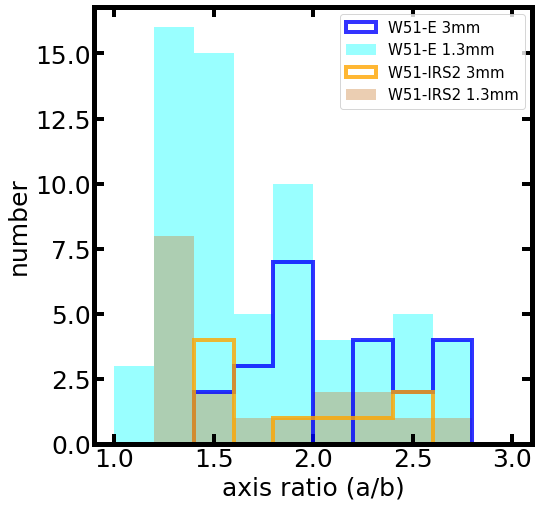

In [3]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_axes([0.18,0.18,0.76,0.76])
w51e_b3_ratio = w51e_b3_major / w51e_b3_minor
w51e_b6_ratio = w51e_b6_major / w51e_b6_minor
w51n_b3_ratio = w51n_b3_major / w51n_b3_minor
w51n_b6_ratio = w51n_b6_major / w51n_b6_minor

bins = np.linspace(1,3,11)
ax1.hist(w51e_b3_ratio, bins=bins, facecolor='none',edgecolor='b', histtype='step',label='W51-E 3mm',lw=4,alpha=0.8)
ax1.hist(w51e_b6_ratio, bins=bins, color='cyan',label='W51-E 1.3mm',lw=4,alpha=0.4)
ax1.hist(w51n_b3_ratio, bins=bins, facecolor='none',edgecolor='orange', histtype='step',label='W51-IRS2 3mm',lw=4,alpha=0.8)
ax1.hist(w51n_b6_ratio, bins=bins, color='peru',label='W51-IRS2 1.3mm',lw=4,alpha=0.4)

ax1.set_xlabel('axis ratio (a/b)')
ax1.set_ylabel('number')

ax1.legend(fontsize=15)
plt.savefig('axis_ratio_hist.png')

[-- -- 1.7902468714171569 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 1.4241746497312873 -- 15.251714984899511 1.9103226816641474 -- -- --
 3.0882631827246465 1.6362250876901534 -- 4.912802341537111
 2.549601595082771 -- 3.3199438700850368 -- 2.31030766604494 -- --
 2.220966683339968 -- -- -- 2.7635046435861668 -- 11.913485062353596 -- --
 -- -- 1.9748173057354366 -- -- -- 2.259160402750685 -- -- -- -- --
 1.9658679873073863 -- 2.6633259519609136 1.9233556817841493
 3.652165296734423 2.2215016104935392 -- -- -- -- -- -- -- -- -- -- -- --
 10.055245097157709 1.893755880997883 1.4282087482125607
 2.6387876314593846 2.6184653100258264 -- -- -- -- -- 1.6001152257811
 1.970182441685258 -- 2.5434640750817072 1.8680620527752092 -- -- -- --
 4.867078193716698 -- -- -- -- --]
[-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -

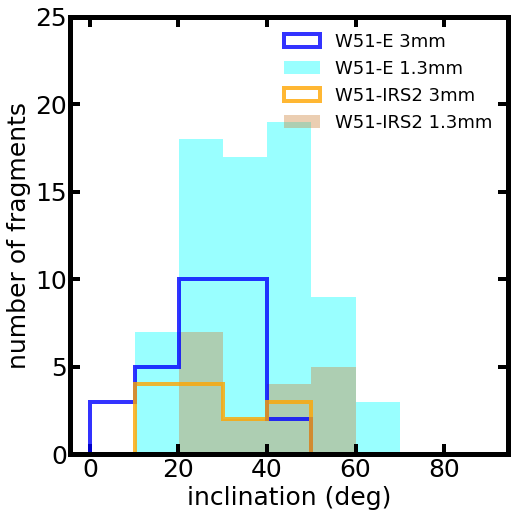

In [4]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_axes([0.18,0.18,0.76,0.76])
print(w51e_b3_ratio.value)
print(np.arcsin(w51e_b3_ratio.value))
w51e_b3_inc = np.degrees(np.arcsin(1/w51e_b3_ratio.value))
w51e_b6_inc = np.degrees(np.arcsin(1/w51e_b6_ratio.value))
w51n_b3_inc = np.degrees(np.arcsin(1/w51n_b3_ratio.value))
w51n_b6_inc = np.degrees(np.arcsin(1/w51n_b6_ratio.value))
print(w51e_b3_inc)

bins = np.linspace(0.1,90,10)
ax1.hist(w51e_b3_inc, bins=bins, facecolor='none',edgecolor='b', histtype='step',label='W51-E 3mm',lw=4,alpha=0.8)
ax1.hist(w51e_b6_inc, bins=bins, color='cyan',label='W51-E 1.3mm',lw=4,alpha=0.4)
ax1.hist(w51n_b3_inc, bins=bins, facecolor='none',edgecolor='orange', histtype='step',label='W51-IRS2 3mm',lw=4,alpha=0.8)
ax1.hist(w51n_b6_inc, bins=bins, color='peru',label='W51-IRS2 1.3mm',lw=4,alpha=0.4)
print(np.nanmin(w51e_b3_inc), np.nanmax(w51e_b3_inc))
ax1.set_xlabel('inclination (deg)')
ax1.set_ylabel('number of fragments')
ax1.legend(fontsize=18, frameon=False)
ax1.set_ylim(0,25)
plt.savefig('inclination.png')

3.7593746776366874 44.60064535159868


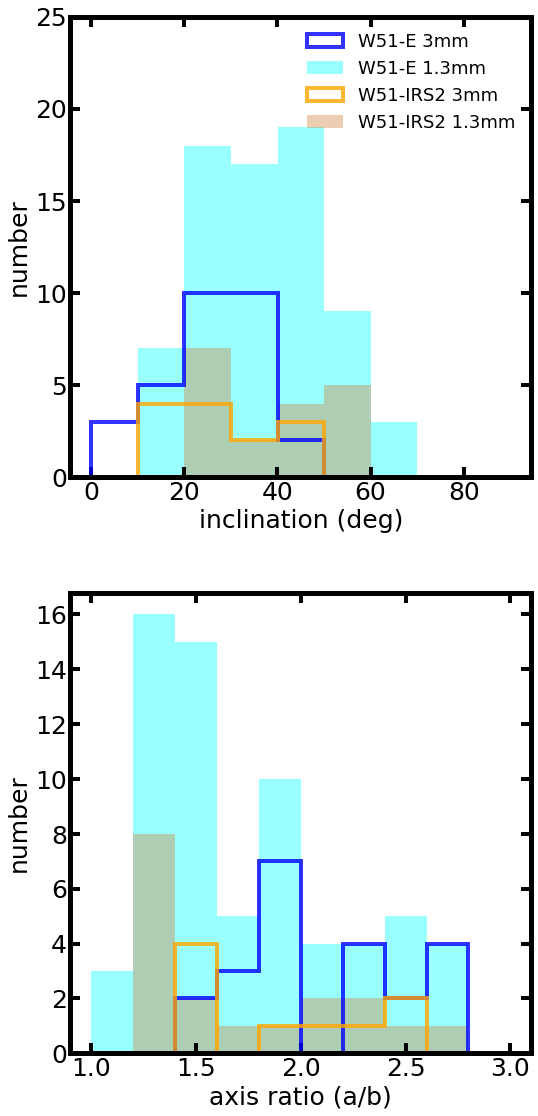

In [7]:
fig = plt.figure(figsize=(8,16))
ax1 = fig.add_axes([0.15,0.58,0.8,0.4])
ax2 = fig.add_axes([0.15,0.08,0.8,0.4])

bins = np.linspace(0.1,90,10)
ax1.hist(w51e_b3_inc, bins=bins, facecolor='none',edgecolor='b', histtype='step',label='W51-E 3mm',lw=4,alpha=0.8)
ax1.hist(w51e_b6_inc, bins=bins, color='cyan',label='W51-E 1.3mm',lw=4,alpha=0.4)
ax1.hist(w51n_b3_inc, bins=bins, facecolor='none',edgecolor='orange', histtype='step',label='W51-IRS2 3mm',lw=4,alpha=0.8)
ax1.hist(w51n_b6_inc, bins=bins, color='peru',label='W51-IRS2 1.3mm',lw=4,alpha=0.4)
print(np.nanmin(w51e_b3_inc), np.nanmax(w51e_b3_inc))
ax1.set_xlabel('inclination (deg)')
ax1.set_ylabel('number')
ax1.legend(fontsize=18, frameon=False)
ax1.set_ylim(0,25)

bins = np.linspace(1,3,11)
ax2.hist(w51e_b3_ratio, bins=bins, facecolor='none',edgecolor='b', histtype='step',label='W51-E 3mm',lw=4,alpha=0.8)
ax2.hist(w51e_b6_ratio, bins=bins, color='cyan',label='W51-E 1.3mm',lw=4,alpha=0.4)
ax2.hist(w51n_b3_ratio, bins=bins, facecolor='none',edgecolor='orange', histtype='step',label='W51-IRS2 3mm',lw=4,alpha=0.8)
ax2.hist(w51n_b6_ratio, bins=bins, color='peru',label='W51-IRS2 1.3mm',lw=4,alpha=0.4)

ax2.set_xlabel('axis ratio (a/b)')
ax2.set_ylabel('number')
plt.savefig('inclination2.png')


NameError: name 'w51e_b3_snr' is not defined

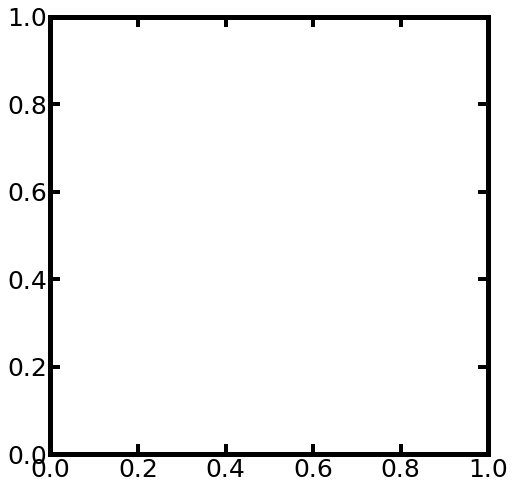

In [6]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_axes([0.18,0.18,0.76,0.76])
bins=np.linspace(1,10,111)
ax1.hist(w51e_b3_snr, bins=bins, facecolor='none',edgecolor='b', histtype='step',label='W51-E B3',lw=4,alpha=0.8)
ax1.hist(w51e_b6_snr, bins=bins, color='cyan',label='W51-E B6',lw=4,alpha=0.4)
ax1.hist(w51n_b3_snr, bins=bins, facecolor='none',edgecolor='orange', histtype='step',label='W51-IRS2 B3',lw=4,alpha=0.8)
ax1.hist(w51n_b6_snr, bins=bins, color='peru',label='W51-IRS2 B6',lw=4,alpha=0.4)




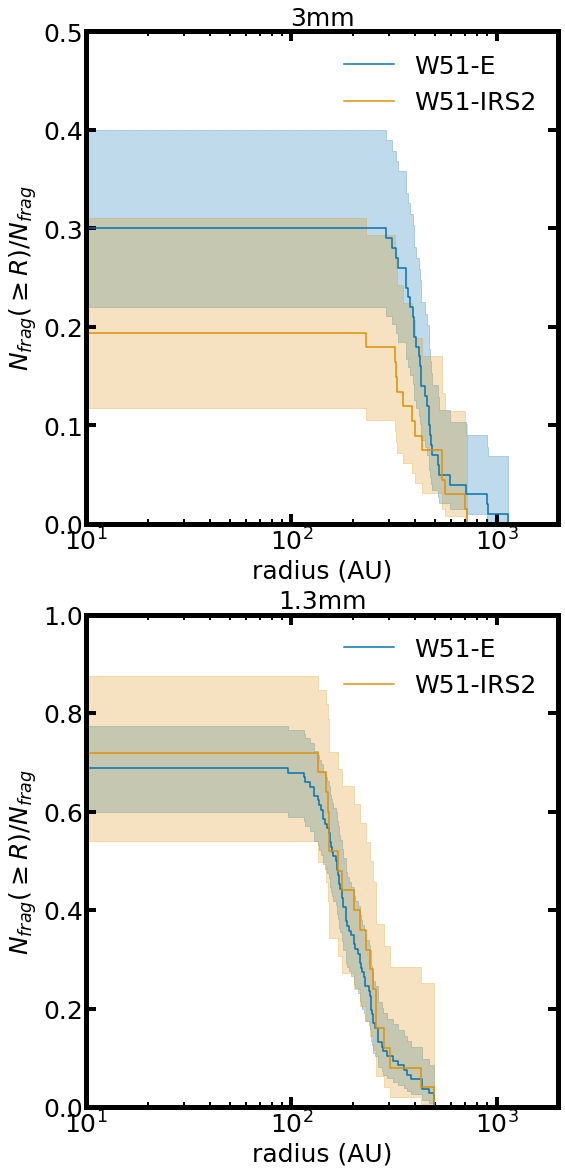

In [ ]:
from lifelines import KaplanMeierFitter
import seaborn as sns

fig = plt.figure(figsize=(8,18))
ax1 = fig.add_axes([0.17,0.1,0.82,0.38])
ax2 = fig.add_axes([0.17,0.55,0.82,0.38])

w51e_b6_rad = w51e_b6_max_size_au*2/2.335
w51e_b3_rad = w51e_b3_max_size_au*2/2.335
w51n_b6_rad = w51n_b6_max_size_au*2/2.335
w51n_b3_rad = w51n_b3_max_size_au*2/2.335

w51e_b6_rad[~np.isfinite(w51e_b6_rad)]=-1
w51n_b6_rad[~np.isfinite(w51n_b6_rad)]=-1
w51e_b3_rad[~np.isfinite(w51e_b3_rad)]=-1
w51n_b3_rad[~np.isfinite(w51n_b3_rad)]=-1

                    
w51e_b6_rad_observed = w51e_b6_rad>0
w51n_b6_rad_observed = w51n_b6_rad>0
w51e_b3_rad_observed = w51e_b3_rad>0
w51n_b3_rad_observed = w51n_b3_rad>0



ax1.set_title('1.3mm')
ax2.set_title('3mm')
#w51e_b6_unresolved = [i for i in range(len(w51e_b6_rad)) if w51e_b6_rad[i]!=0 or not np.isfinite(w51e_b6_rad[i])]
#w51e_b6_unresolved = [i for i in range(len(w51e_b3_rad)) if w51e_b3_rad[i]!=0 or not np.isfinite(w51e_b3_rad[i])]
#w51e_b6_unresolved = [i for i in range(len(w51n_b6_rad)) if w51n_b6_rad[i]!=0 or not np.isfinite(w51n_b6_rad[i])]
#w51e_b6_unresolved = [i for i in range(len(w51n_b3_rad)) if w51n_b3_rad[i]!=0 or not np.isfinite(w51n_b3_rad[i])]
"""
w51e_b6_rad[~w51e_b6_unresolved] = w51e_b6_min_size*2/2.355
w51e_b3_rad[~w51e_b3_unresolved] = w51e_b3_min_size*2/2.355
w51n_b6_rad[~w51n_b6_unresolved] = w51n_b6_min_size*2/2.355
w51n_b3_rad[~w51n_b3_unresolved] = w51n_b3_min_size*2/2.355
"""
#w51e_b6_rad[w51e_b6_unresolved] = 0
#w51e_b3_rad[w51e_b3_unresolved] = 0
#w51n_b6_rad[w51n_b6_unresolved] = 0
#w51n_b3_rad[w51n_b3_unresolved] = 0
#w51e_b6_rad.pprint(max_lines=500)
cmap = sns.color_palette("colorblind")

kmf = KaplanMeierFitter(label='W51-E')
kmf.fit_left_censoring(w51e_b6_rad, w51e_b6_rad_observed)
kmf.plot_survival_function(ax=ax1,color=cmap[0])

#kmf = KaplanMeierFitter(label='W51-E B3')
#kmf.fit_left_censoring(w51e_b3_rad, w51e_b3_unresolved)
#kmf.plot_survival_function(ax=ax1,color='cyan')

kmf = KaplanMeierFitter(label='W51-IRS2')
kmf.fit_left_censoring(w51n_b6_rad, w51n_b6_rad_observed)
kmf.plot_survival_function(ax=ax1,color=cmap[1])


cmap = sns.color_palette("colorblind")

kmf = KaplanMeierFitter(label='W51-E')
kmf.fit_left_censoring(w51e_b3_rad, w51e_b3_rad_observed)
kmf.plot_survival_function(ax=ax2,color=cmap[0], ci_legend=False)

#kmf = KaplanMeierFitter(label='W51-E B3')
#kmf.fit_left_censoring(w51e_b3_rad, w51e_b3_unresolved)
#kmf.plot_survival_function(ax=ax1,color='cyan')

kmf = KaplanMeierFitter(label='W51-IRS2')
kmf.fit_left_censoring(w51n_b3_rad, w51n_b3_rad_observed)
kmf.plot_survival_function(ax=ax2,color=cmap[1], ci_legend=False)
"""
##kmf = KaplanMeierFitter(label='W51-IRS2 B3')
#kmf.fit_left_censoring(w51n_b3_rad, w51n_b3_unresolved)
#kmf.plot_survival_function(ax=ax1,color='orange')

#ax1.vlines(w51e_b6_min_size,0,1,color=cmap[0],lw=2,ls='dashed')
#ax1.vlines(w51e_b3_min_size,0,1,color=cmap[2],lw=2,ls='dashed')
#ax1.vlines(w51n_b6_min_size,0,1,color=cmap[1],lw=2,ls='dashed')

#ax1.vlines(w51n_b3_min_size,0,1,color=cmap[3],lw=2,ls='dashed')
tobin20 = fits.open('../tobin20_alma.fit')
tobin20_field = fits.open('../tobin20_almafields.fit')

data = tobin20[1].data
data_field = tobin20_field[1].data
sedclass = data.field(1)
almafieldname1 = data.field(0)
almafieldname2 = data_field.field(0)

dist = data_field.field(3)
size_ang = data.field(4)
size_au_tobin20 = []
for i in range(len(almafieldname1)):
    ind_search = np.where(almafieldname2==almafieldname1[i])[0]
    if len(ind_search)>1:
        ind_search = ind_search[0]
    size = size_ang[i] * dist[ind_search] *2/2.355
    size_au_tobin20.append(size.item())
size_au_tobin20 = np.array(size_au_tobin20)

size_au_tobin20[~np.isfinite(size_au_tobin20)]=-1

size_au_class0_tobin20 = []
size_au_classI_tobin20 = []
size_au_classFlat_tobin20 = []
for i in range(len(size_au_tobin20)):
    if sedclass[i]=='0':
        size_au_class0_tobin20.append(size_au_tobin20[i])
    elif sedclass[i]=='I':
        size_au_classI_tobin20.append(size_au_tobin20[i])
    elif sedclass[i]=='Flat':
        size_au_classFlat_tobin20.append(size_au_tobin20[i])


size_au_class0_tobin20_observed = np.array(size_au_class0_tobin20)>0
size_au_classI_tobin20_observed = np.array(size_au_classI_tobin20)>0
size_au_classFlat_tobin20_observed = np.array(size_au_classFlat_tobin20)>0
kmf = KaplanMeierFitter(label='Tobin+20\nClass 0 (0.87 mm)')
kmf.fit_left_censoring(size_au_class0_tobin20, size_au_class0_tobin20_observed)
kmf.plot_survival_function(ax=ax1,color='seagreen')

kmf = KaplanMeierFitter(label='Tobin+20\nClass I (0.87 mm)')
kmf.fit_left_censoring(size_au_classI_tobin20, size_au_classI_tobin20_observed)
kmf.plot_survival_function(ax=ax1,color='mediumseagreen')

kmf = KaplanMeierFitter(label='Tobin+20\nFlat (0.87 mm)')
kmf.fit_left_censoring(size_au_classFlat_tobin20, size_au_classFlat_tobin20_observed)
kmf.plot_survival_function(ax=ax1,color='springgreen')
"""
ax1.set_xscale('log')
ax1.set_xlim(10,2000)
ax1.set_xlabel('radius (AU)')
#ax1.set_ylabel(r'Fraction with $\geq R$')
ax1.set_ylim(0,1)

ax1.legend(fontsize=25, frameon=False)
ax2.legend(fontsize=25, frameon=False)

ax2.set_xscale('log')
ax2.set_xlim(10,2000)
ax2.set_xlabel('radius (AU)')
ax1.set_ylabel(r'$N_{frag}(\geq R)/N_{frag}$')
ax2.set_ylabel(r'$N_{frag}(\geq R)/N_{frag}$')
ax2.set_yticks([0,0.1,0.2,0.3,0.4,0.5])
ax2.set_ylim(0,0.5)
plt.savefig('size_cumul.png')

In [ ]:
w51e_b6_major_conv = w51e_b6_flux_conv_fits['deconvolved_major']
w51n_b6_major_conv = w51n_b6_flux_conv_fits['deconvolved_major']
w51e_b6_minor_conv = w51e_b6_flux_conv_fits['deconvolved_minor']
w51n_b6_minor_conv = w51n_b6_flux_conv_fits['deconvolved_minor']

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_axes([0.18,0.18,0.76,0.76])
print(len(w51e_b6_major_conv),len(w51e_b3_major))
print(len(w51n_b6_major_conv),len(w51n_b3_major))

ax1.scatter(w51e_b6_major_conv,w51e_b3_major/w51e_b6_major_conv, label='W51-E major',s=10)
ax1.scatter(w51n_b6_major_conv,w51n_b3_major/w51n_b6_major_conv, label='W51-IRS2 major',s=10)
ax1.scatter(w51e_b6_minor_conv,w51e_b3_minor/w51e_b6_minor_conv, label='W51-E minor',s=10)
ax1.scatter(w51n_b6_minor_conv,w51n_b3_minor/w51n_b6_minor_conv, label='W51-IRS2 minor',s=10)
print(w51e_b6_minor_conv,w51e_b3_minor)
ax1.set_xlabel('$FWHM_{B6, conv}$')
ax1.set_ylabel('$FWHM_{B3}/FWHM_{B6, conv}$ ')
ax1.set_yscale('linear')
ax1.set_xscale('log')
ax1.legend()
ax1.set_ylim(0,2)

In [ ]:
w51e_b6_major = w51e_b6_flux_fits['deconvolved_major']
w51n_b6_major = w51n_b6_flux_fits['deconvolved_major']
w51e_b6_minor= w51e_b6_flux_fits['deconvolved_minor']
w51n_b6_minor = w51n_b6_flux_fits['deconvolved_minor']

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_axes([0.18,0.18,0.76,0.76])
print(len(w51e_b6_major_conv),len(w51e_b3_major))
print(len(w51n_b6_major_conv),len(w51n_b3_major))

ax1.scatter(w51e_b6_major,w51e_b3_major/w51e_b6_major, label='W51-E major',s=10)
ax1.scatter(w51n_b6_major,w51n_b3_major/w51n_b6_major, label='W51-IRS2 major',s=10)
ax1.scatter(w51e_b6_minor,w51e_b3_minor/w51e_b6_minor, label='W51-E minor',s=10)
ax1.scatter(w51n_b6_minor,w51n_b3_minor/w51n_b6_minor, label='W51-IRS2 minor',s=10)
print(w51e_b6_minor_conv,w51e_b3_minor)
ax1.set_xlabel('$FWHM_{B6}$')
ax1.set_ylabel('$FWHM_{B3}/FWHM_{B6}$ ')
ax1.set_yscale('linear')
ax1.set_xscale('log')
ax1.legend()
ax1.set_ylim(0,5)

In [ ]:


fig = plt.figure(figsize=(8,8))
ax1 = fig.add_axes([0.18,0.18,0.76,0.76])
print(len(w51e_b6_major_conv),len(w51e_b3_major))
print(len(w51n_b6_major_conv),len(w51n_b3_major))

ax1.scatter(w51e_b6_major,w51e_b6_major_conv/w51e_b6_major, label='W51-E major',s=10)
ax1.scatter(w51n_b6_major,w51n_b6_major_conv/w51n_b6_major, label='W51-IRS2 major',s=10)
ax1.scatter(w51e_b6_minor,w51e_b6_minor_conv/w51e_b6_minor, label='W51-E minor',s=10)
ax1.scatter(w51n_b6_minor,w51n_b6_minor_conv/w51n_b6_minor, label='W51-IRS2 minor',s=10)
print(w51e_b6_minor_conv,w51e_b3_minor)
ax1.set_xlabel('$FWHM_{B6}$')
ax1.set_ylabel('$FWHM_{B6, conv}/FWHM_{B6}$ ')
ax1.set_yscale('linear')
ax1.set_xscale('log')
ax1.legend()
ax1.set_ylim(0,5)